In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import os

# choose a local (colab) directory to store the data.
local_root_path = os.path.expanduser("~/data")
try:
  os.makedirs(local_root_path)
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # If it is a directory then, create the dicrectory and upload the file inside it
    if f['mimeType']=='application/vnd.google-apps.folder': 
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path)
      print('creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('{} files were uploaded in {}'.format(counter, destination))

ListFolder("1hUDbiqk66s8B3zN_NDqXCsZS7nRn_f_3", local_root_path)

4 files were uploaded in /root/data


In [3]:
from requests import get
import json
import re 
from textblob import TextBlob
import datetime
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import sys
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [4]:
# build the model
model = Sequential()
model.add(LSTM(128, input_shape=(21,1), return_sequences=True))
model.add(LSTM(64, input_shape=(21,1)))

model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="mse")

In [50]:
# len to maxscaler
file_to_framesize = {
    'AAPL' : 7500,
    'DIS' : 10000,
    'GS' : 2500,
    'CSCO' : 5000
}

# load all stock files
files = [f for f in listdir("/root/data") if isfile(
    join("/root/data", f))]

# iterate stock files for building and training model model
for file in files:
    print(file)
    file_name = file[:-4]
    # source path to train data
    source_file_path = "/root/data/" + file
    
    # read in data as df
    df = pd.read_csv(source_file_path)
    
    # add new column Open_before which contains the open values of the previous day
    df["Open_before"] = df["Open"].shift(1)

    # calculate the procentual change of the open value of the current day to the 
    # open value of the day before
    df["Open_changes"] = (df["Open"] / df["Open_before"]) - 1

    # throw out the first line which has NaN as value because of the previous shift of values 
    df = df.dropna()

    # reset index to start by 0
    df.index -= 1
    
    # resort data frame by start backwards
    df = df[::-1]
    
    changes = df["Open_changes"]
    sentiments = df["Sentiment"]
    
    sentiments = sentiments.reindex(range(0, len(sentiments)))
    
    # build test and training data
    train = np.array(changes).reshape(-1, 1)

    scaler = MinMaxScaler()

    # train the scaler with training data and smooth data
    smoothing_window_size = 2500
    for di in range(0, file_to_framesize[file_name], smoothing_window_size):
        scaler.fit(train[di:di+smoothing_window_size,:])
        train[di:di+smoothing_window_size,:] = scaler.transform(train[di:di+smoothing_window_size,:])

    # normalize the rest of the data which is len(train) - 10000
    scaler.fit(train[di+smoothing_window_size:,:])
    train[di+smoothing_window_size:,:] = scaler.transform(train[di+smoothing_window_size:,:])

    # reshape test and train data
    train = train.reshape(-1)
    
    # perform exponential moving average
    EMA = 0.0
    gamma = 0.1
    for ti in range(len(train)):
        EMA = gamma * train[ti] + (1 - gamma) * EMA
        train[ti] = EMA
    
    # calculate train and test data with sentiments
    train_len = len(train)

    Y_train = []
    X_train = []

    # X data with additional value for the sentiment
    for i in range(0, len(train)- 20):
        Y_train.append(train[i])
        to_add = train[i+1:i+21].tolist()
        to_add.append(sentiments[i])
        X_train.append(to_add)
    
    X_train = np.array(X_train).reshape(-1, 21, 1)
    
    # train model
    model.fit(X_train, Y_train, batch_size=32, epochs=10)
    
    # print out which stock is done
    print(file + " done!")

CSCO.csv
Epoch 1/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.8713e-04
Epoch 2/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.5304e-04
Epoch 3/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.5067e-04
Epoch 4/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.5152e-04
Epoch 5/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.4955e-04
Epoch 6/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.5080e-04
Epoch 7/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.5052e-04
Epoch 8/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.4518e-04
Epoch 9/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.4119e-04
Epoch 10/10
7430/7430 [==============================] - 16s 2ms/step - loss: 1.4672e-04
CSCO.csv done!
GS.csv
Epoch 1/10
5104/5104 [==============================] - 11s 2ms/step - loss: 1.3917e-04


In [0]:
model.save('./multiple-layer-with-normalization-with-sentiments-dow-jones-set-1.h5')

In [0]:
predictions = model.predict(X_train)

In [0]:
predictions = predictions.reshape(-1)

In [0]:
predictions = np.append(predictions, np.zeros(20))

In [55]:
len(df)

14524

In [56]:
predictions.shape

(14524,)

In [0]:
df["predictions"] = predictions

In [0]:
df["Open_predicted"] = df["Open_before"] * (1 + df["predictions"])

<function matplotlib.pyplot.show>

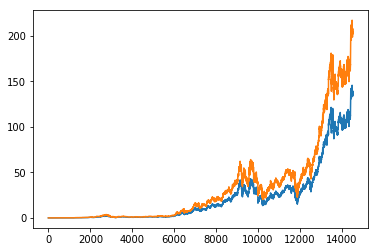

In [71]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import drange

plt.plot(df.index, df["Open"])
plt.plot(df.index, df["Open_predicted"])

plt.show

'1962-01-03'